# Animal Counting using Traditional Image Processing

This notebook demonstrates how to count animals in images using basic image processing techniques without deep learning models.

In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os

Loading images from Counting folder...
Counting\cat.jpg
Loaded: cat.jpg
Counting\mouse.jpg
Loaded: mouse.jpg
Counting\pair_boot.jpg
Loaded: pair_boot.jpg
Counting\rabbit.jpeg
Loaded: rabbit.jpeg
Counting\rabbit2.png
Loaded: rabbit2.png
Loaded 5 images from Counting folder.

Loading images from Finding folder...
Finding\1.jpg
Loaded: 1.jpg
Finding\2.jpg
Loaded: 2.jpg
Finding\3.jpg
Loaded: 3.jpg
Loaded 3 images from Finding folder.


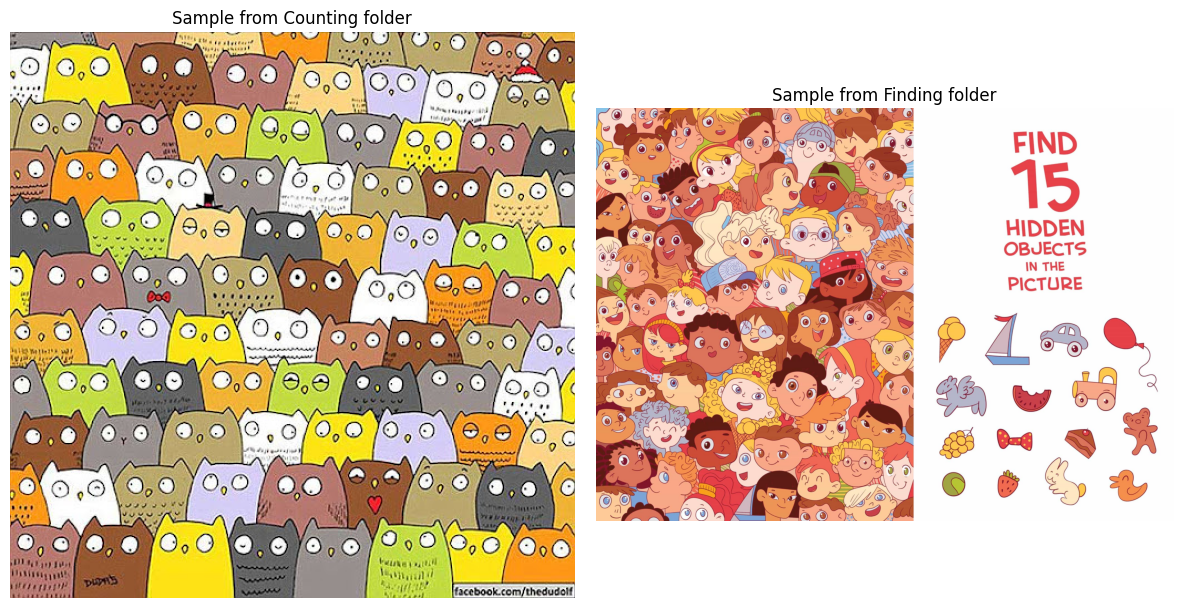

In [3]:
images_counting = []
images_finding = []

# Function to read all images from a folder
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        # Check if the file is an image (you can add more extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            print(img_path)
            img = cv2.imread(img_path)
            if img is not None:
                # Convert from BGR to RGB for display purposes
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                print(f"Loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")
    return images

# Define paths to the Counting and Finding folders
counting_folder_path = "Counting"
finding_folder_path = "Finding"

# Load images from both folders
print("Loading images from Counting folder...")
images_counting = read_images_from_folder(counting_folder_path)
print(f"Loaded {len(images_counting)} images from Counting folder.\n")

print("Loading images from Finding folder...")
images_finding = read_images_from_folder(finding_folder_path)
print(f"Loaded {len(images_finding)} images from Finding folder.")

# Display a sample image from each folder if available
plt.figure(figsize=(12, 6))

if len(images_counting) > 0:
    plt.subplot(1, 2, 1)
    plt.imshow(images_counting[0])
    plt.title("Sample from Counting folder")
    plt.axis('off')

if len(images_finding) > 0:
    plt.subplot(1, 2, 2)
    plt.imshow(images_finding[0])
    plt.title("Sample from Finding folder")
    plt.axis('off')

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.float64'>
Match Location: (242, 98)


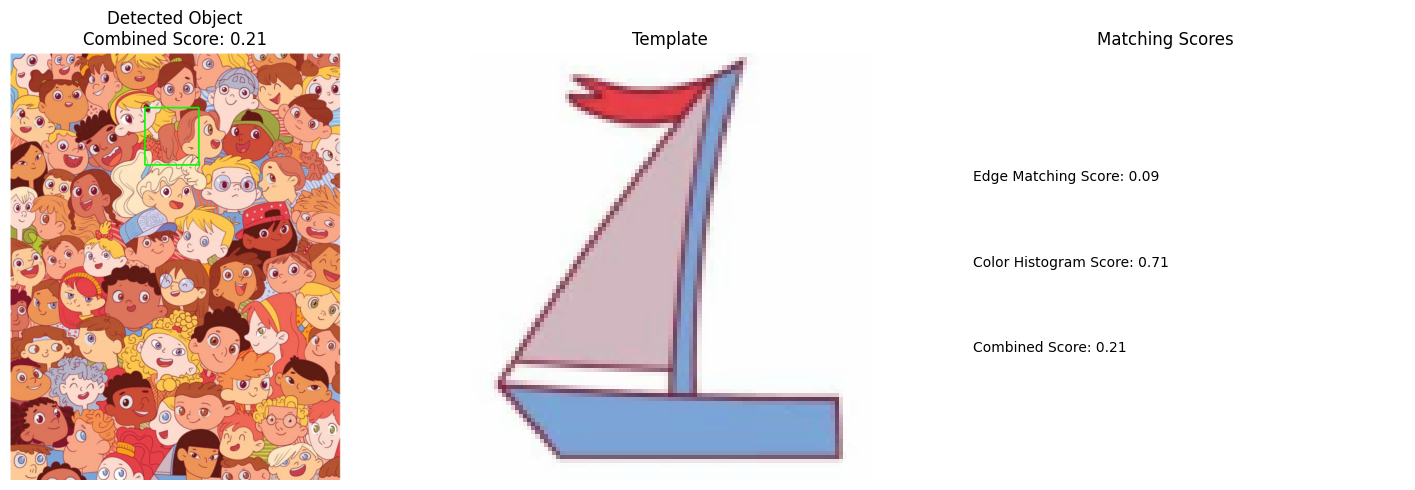

Match Location: (242, 98)
Edge Matching Score: 0.09
Color Histogram Score: 0.71
Combined Score: 0.21


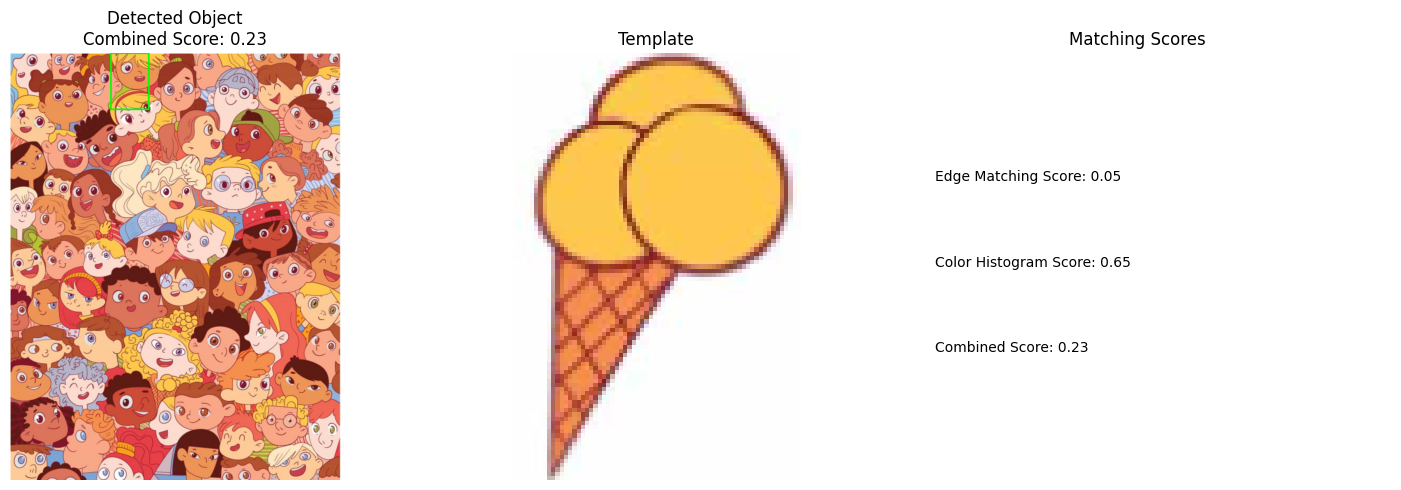

Match Location: (181, 0)
Edge Matching Score: 0.05
Color Histogram Score: 0.65
Combined Score: 0.23


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_color_histogram(image):
    """
    Compute color histogram for the given image.
    
    Args:
    image (numpy.ndarray): Input image
    
    Returns:
    numpy.ndarray: Normalized color histogram
    """
    # Convert to HSV color space for more robust color matching
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Compute histogram
    hist = cv2.calcHist([hsv_image], [0, 1], None, [180, 256], [0, 180, 0, 256])
    
    # Normalize the histogram
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    return hist

def compare_color_histograms(hist1, hist2):
    """
    Compare two color histograms using multiple methods.
    
    Args:
    hist1 (numpy.ndarray): First histogram
    hist2 (numpy.ndarray): Second histogram
    
    Returns:
    float: Averaged histogram comparison score
    """
    # Use multiple comparison methods
    methods = [
        cv2.HISTCMP_CORREL,  # Correlation
        cv2.HISTCMP_INTERSECT,  # Intersection
    ]
    
    scores = [cv2.compareHist(hist1, hist2, method) for method in methods]
    return np.mean(scores)

def comprehensive_template_matching(main_image, template):
    """
    Find the best template match by evaluating multiple locations.
    
    Args:
    main_image (numpy.ndarray): Main image to search in
    template (numpy.ndarray): Template to find
    
    Returns:
    tuple: Best match location, edge score, color score, and combined score
    """
    # Convert images to grayscale for edge detection
    main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    main_edges = cv2.Canny(main_gray, 50, 200)
    template_edges = cv2.Canny(template_gray, 50, 200)
    
    # Perform template matching on edges
    edge_result = cv2.matchTemplate(main_edges, template_edges, cv2.TM_CCOEFF_NORMED)
    
    # Compute color histograms for template
    template_hist = compute_color_histogram(template)
    
    # Height and width of template
    h, w = template.shape[:2]
    
    # Initialize variables to track best match
    best_location = None
    best_edge_score = -np.inf
    best_color_score = -np.inf
    best_combined_score = -np.inf
    
    # Iterate through all potential matches
    for y in range(edge_result.shape[0]):
        for x in range(edge_result.shape[1]):
            # Current edge matching score
            current_edge_score = edge_result[y, x]
            
            # Extract region of interest from main image
            roi = main_image[y:y+h, x:x+w]
            
            # Skip if ROI is smaller than template
            if roi.shape[0] != h or roi.shape[1] != w:
                continue
            
            # Compute color histogram for ROI
            roi_hist = compute_color_histogram(roi)
            
            # Compare color histograms
            color_score = compare_color_histograms(template_hist, roi_hist)
            
            # Combine scores (you can adjust weights as needed)
            combined_score = 0.7*current_edge_score + 0.3*color_score
            
            # Update best match if current score is higher
            if combined_score > best_combined_score:
                best_location = (x, y)
                best_edge_score = current_edge_score
                best_color_score = color_score
                best_combined_score = combined_score
    
    return best_location, best_edge_score, best_color_score, best_combined_score

# Load images
main_image = cv2.imread("Finding/image.png")
template = cv2.imread("Template/ice_cream.png")

# Perform comprehensive template matching
match_location, edge_score, color_score, combined_score = comprehensive_template_matching(main_image, template)

# Height and width of template
h, w = template.shape[:2]

# Visualize results
# Draw rectangle on the matched location
output_image = main_image.copy()
cv2.rectangle(output_image, match_location, 
              (match_location[0] + w, match_location[1] + h), 
              (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
template_rgb = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(output_image_rgb)
plt.title(f"Detected Object\nCombined Score: {combined_score:.2f}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(template_rgb)
plt.title("Template")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Matching Scores")
plt.text(0.1, 0.7, f"Edge Matching Score: {edge_score:.2f}", fontsize=10)
plt.text(0.1, 0.5, f"Color Histogram Score: {color_score:.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Combined Score: {combined_score:.2f}", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Match Location: {match_location}")
print(f"Edge Matching Score: {edge_score:.2f}")
print(f"Color Histogram Score: {color_score:.2f}")
print(f"Combined Score: {combined_score:.2f}")

Best match found at (2211, 1257) with scale 1.83


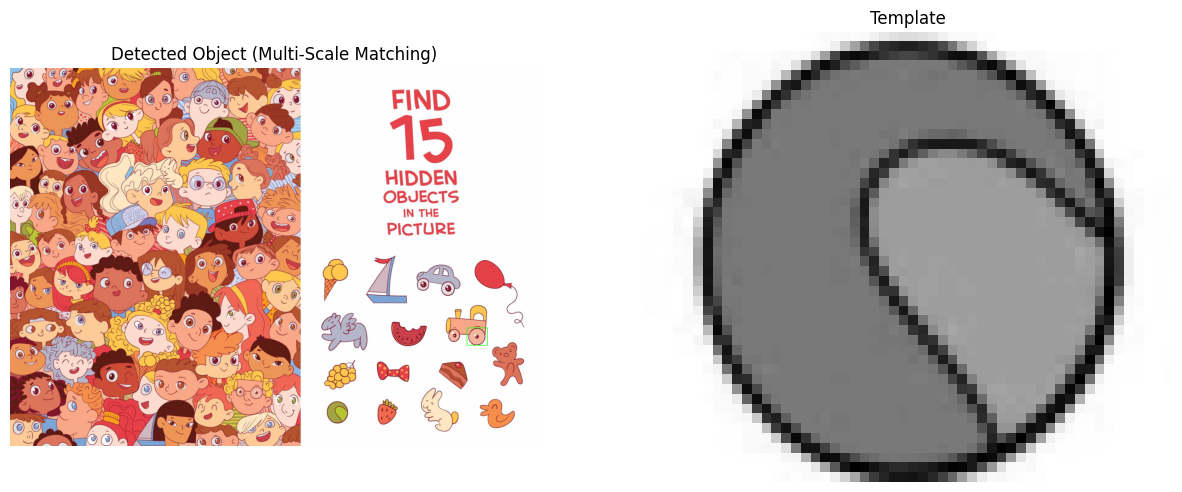

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the main image
main_image = cv2.imread("Finding/1.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("Template/tenis.png", cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
main_edges = cv2.Canny(main_image, 100, 200)

# Scale range
scales = np.linspace(0.5, 2.0, 10)  # Scale from 50% to 200% in 10 steps
best_match = None
best_val = -np.inf
best_scale = 1.0
best_loc = None
best_size = None

for scale in scales:
    resized_template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    
    if resized_template.shape[0] > main_edges.shape[0] or resized_template.shape[1] > main_edges.shape[1]:
        continue  # Skip if the resized template is bigger than the main image

    # Apply Canny edge detection to the resized template
    template_edges = cv2.Canny(resized_template, 100, 200)

    # Perform template matching
    result = cv2.matchTemplate(main_edges, template_edges, cv2.TM_CCOEFF_NORMED)

    # Get the best match position
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Store the best match
    if max_val > best_val:
        best_val = max_val
        best_match = max_loc
        best_scale = scale
        best_size = resized_template.shape[:2]

# Load the original image in color
output_image = cv2.imread("Finding/1.jpg")

if best_match:
    top_left = best_match
    h, w = best_size
    cv2.rectangle(output_image, top_left, (top_left[0] + w, top_left[1] + h), (0, 255, 0), 2)
    print(f"Best match found at {top_left} with scale {best_scale:.2f}")

# Convert BGR to RGB for Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the results using Matplotlib
plt.figure(figsize=(15, 10))

# Show the detected object
plt.subplot(1, 2, 1)
plt.imshow(output_image_rgb)
plt.title("Detected Object (Multi-Scale Matching)")
plt.axis("off")

# Show the template
plt.subplot(1, 2, 2)
plt.imshow(template, cmap="gray")
plt.title("Template")
plt.axis("off")

plt.show()


(-0.5, 2559.5, 1828.5, -0.5)

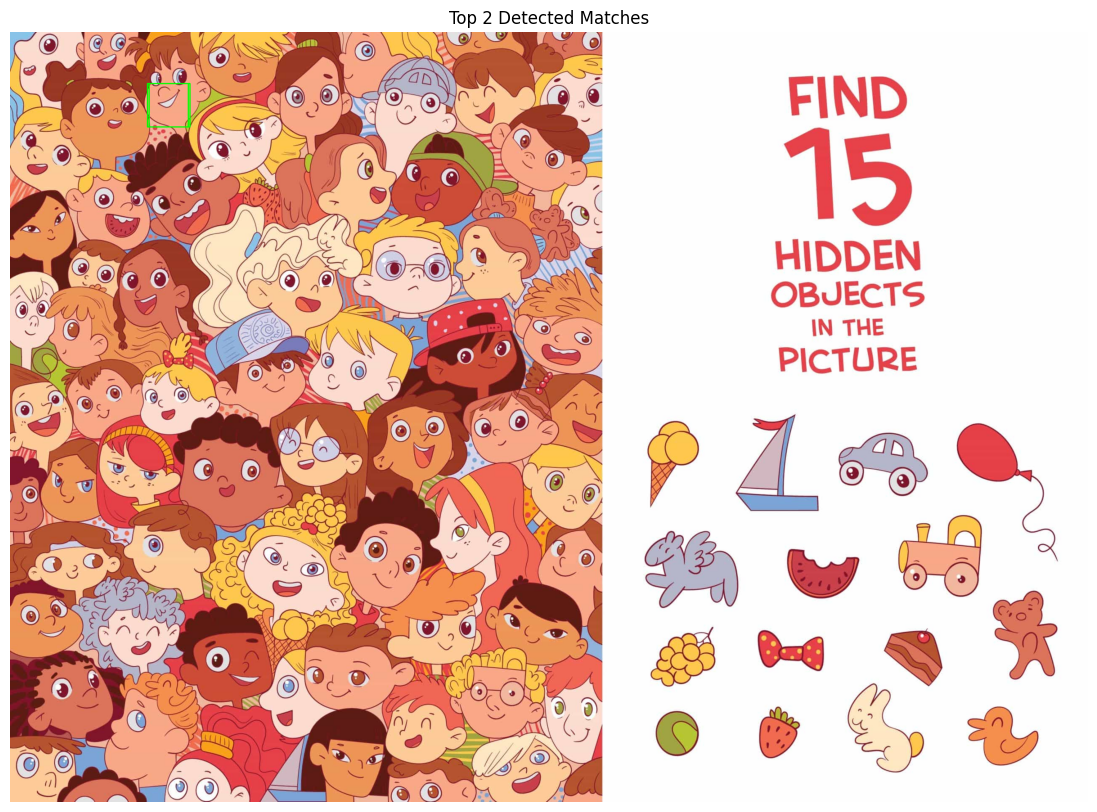

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the main image and template
main_image = cv2.imread("Finding/image.png", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("Template/boat.png", cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
main_edges = cv2.Canny(main_image, 50, 200)
template_edges = cv2.Canny(template, 50, 200)

# Perform template matching
result = cv2.matchTemplate(main_edges, template_edges, cv2.TM_CCOEFF_NORMED)

# Flatten result and get top 2 indices
result_flattened = result.ravel()  # Flatten 2D array
top_2_indices = np.argpartition(result_flattened, -2)[-2:]  # Get indices of top 2 values
top_2_indices = top_2_indices[np.argsort(result_flattened[top_2_indices])][::-1]  # Sort descending

# Convert flattened indices back to 2D coordinates
top_matches = [np.unravel_index(idx, result.shape) for idx in top_2_indices]

# Load the original image in color
output_image = cv2.imread("Finding/1.jpg")

# Get template size
h, w = template.shape[:2]

# Draw rectangles around the top 2 matches
for pt in top_matches:
    top_left = (pt[1], pt[0])  # Convert (row, col) to (x, y)
    cv2.rectangle(output_image, top_left, (top_left[0] + w, top_left[1] + h), (0, 255, 0), 2)

# Convert BGR to RGB for Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the images using Matplotlib
plt.figure(figsize=(45, 10))

# Show the original image with detection
plt.subplot(1, 2, 1)
plt.imshow(output_image_rgb)
plt.title("Top 2 Detected Matches")
plt.axis("off")

# # Show the template
# plt.subplot(1, 2, 2)
# plt.imshow(template, cmap="gray")
# plt.title("Template")
# plt.axis("off")

# plt.show()


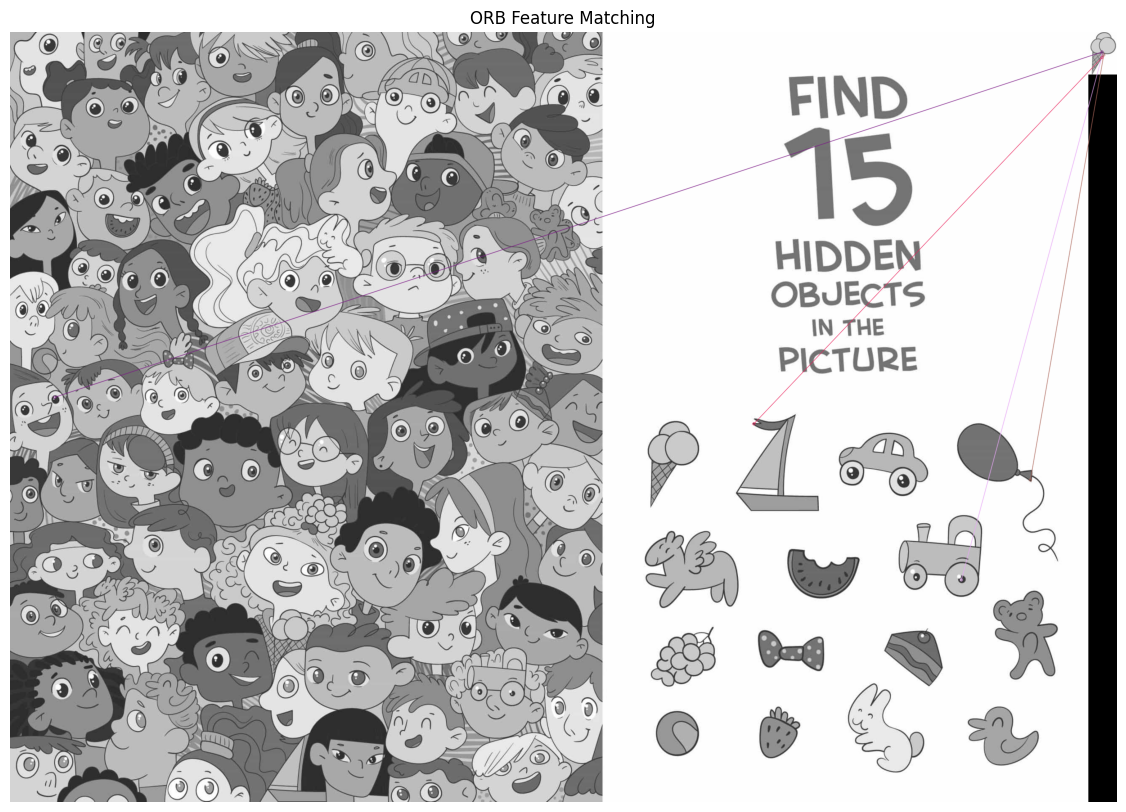

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
main_image = cv2.imread("Finding/1.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("Template/ice_cream.png", cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=500)

# Detect keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(main_image, None)
keypoints2, descriptors2 = orb.detectAndCompute(template, None)

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the best matches
result_image = cv2.drawMatches(main_image, keypoints1, template, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display results
plt.figure(figsize=(15, 10))
plt.imshow(result_image, cmap="gray")
plt.title("ORB Feature Matching")
plt.axis("off")
plt.show()


In [57]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load images
# main_image = cv2.imread("Finding/1.jpg", cv2.IMREAD_GRAYSCALE)
# template = cv2.imread("Template/tenis.png", cv2.IMREAD_GRAYSCALE)

# # Initialize SIFT detector
# sift = cv2.SIFT_create(nfeatures=1000)  # More features for better matching

# # Detect keypoints and compute descriptors
# keypoints1, descriptors1 = sift.detectAndCompute(main_image, None)
# keypoints2, descriptors2 = sift.detectAndCompute(template, None)

# # Use FLANN-based matcher
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
# search_params = dict(checks=50)

# flann = cv2.FlannBasedMatcher(index_params, search_params)

# # Match descriptors using KNN
# matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# # Apply Lowe’s ratio test
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.85 * n.distance:  # Adjusted from 0.75 to 0.8
#         good_matches.append(m)

# # Ensure there are enough good matches for homography
# if len(good_matches) > 10:
#     # Get keypoint coordinates
#     src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
#     dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

#     # Compute Homography using RANSAC
#     M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
#     # Get the size of the template
#     h, w = template.shape[:2]
#     pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

#     # Transform the template bounding box using Homography
#     dst = cv2.perspectiveTransform(pts, M)

#     # Load the original image in color
#     output_image = cv2.imread("Finding/1.jpg")

#     # Draw transformed bounding box
#     cv2.polylines(output_image, [np.int32(dst)], True, (0, 255, 0), 3)

#     # Convert BGR to RGB for Matplotlib
#     output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

#     # Show results
#     plt.figure(figsize=(15, 10))
#     plt.imshow(output_image_rgb)
#     plt.title("Corrected Object Detection with Homography")
#     plt.axis("off")
#     plt.show()

# else:
#     print("Not enough good matches found!")


In [77]:
import numpy as np
import cv2
import os

def preprocess_image(image, blur_kernel=(5,5), canny_low=30, canny_high=150):
    """
    Advanced image preprocessing pipeline
    
    Parameters:
    - image: Input grayscale image
    - blur_kernel: Gaussian blur kernel size
    - canny_low: Lower threshold for Canny edge detection
    - canny_high: Higher threshold for Canny edge detection
    
    Returns:
    - Preprocessed image
    """
    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, blur_kernel, 0)
    
    # Adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    
    # Canny edge detection
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    return {
        'blurred': blurred,
        'adaptive_thresh': adaptive_thresh,
        'edges': edges
    }

# Create output directory
output_dir = 'template_matching_results'
os.makedirs(output_dir, exist_ok=True)

# Preprocessing parameter sets to experiment with
preprocessing_configs = [
    {
        'name': 'gaussian_5x5_30_150',
        'blur_kernel': (5, 5),
        'canny_low': 30,
        'canny_high': 150
    },
    {
        'name': 'gaussian_3x3_20_100',
        'blur_kernel': (3, 3),
        'canny_low': 20,
        'canny_high': 100
    },
    {
        'name': 'gaussian_7x7_50_200',
        'blur_kernel': (7, 7),
        'canny_low': 50,
        'canny_high': 200
    }
]

# Read original images
img = cv2.imread('Finding/1.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (0, 0), fx=0.8, fy=0.8)

template = cv2.imread('Template/tenis.png', cv2.IMREAD_GRAYSCALE)
template = cv2.resize(template, (0, 0), fx=0.8, fy=0.8)

# Read original color image for drawing rectangles
img_color = cv2.imread('Finding/1.jpg')
img_color = cv2.resize(img_color, (0, 0), fx=0.8, fy=0.8)

# Different template matching methods
methods = [
    cv2.TM_CCOEFF, 
    cv2.TM_CCOEFF_NORMED, 
    cv2.TM_CCORR,
    cv2.TM_CCORR_NORMED, 
    cv2.TM_SQDIFF, 
    cv2.TM_SQDIFF_NORMED
]

method_names = [
    'TM_CCOEFF', 
    'TM_CCOEFF_NORMED', 
    'TM_CCORR', 
    'TM_CCORR_NORMED', 
    'TM_SQDIFF', 
    'TM_SQDIFF_NORMED'
]

# Iterate through preprocessing configurations
for config in preprocessing_configs:
    # Preprocess images
    img_processed = preprocess_image(
        img, 
        blur_kernel=config['blur_kernel'], 
        canny_low=config['canny_low'], 
        canny_high=config['canny_high']
    )
    
    template_processed = preprocess_image(
        template, 
        blur_kernel=config['blur_kernel'], 
        canny_low=config['canny_low'], 
        canny_high=config['canny_high']
    )
    
    # Save intermediate processing results
    for key, processed_img in img_processed.items():
        cv2.imwrite(os.path.join(output_dir, f'{config["name"]}_main_{key}.jpg'), processed_img)
    
    for key, processed_img in template_processed.items():
        cv2.imwrite(os.path.join(output_dir, f'{config["name"]}_template_{key}.jpg'), processed_img)
    
    # Perform template matching on different preprocessing results
    preprocessing_types = ['blurred', 'adaptive_thresh', 'edges']
    
    for preprocess_type in preprocessing_types:
        # Select the appropriate preprocessed image
        img_match = img_processed[preprocess_type]
        template_match = template_processed[preprocess_type]
        
        # Get template dimensions
        h, w = template_match.shape
        
        for method, method_name in zip(methods, method_names):
            # Perform template matching
            result = cv2.matchTemplate(img_match, template_match, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            
            # Determine location based on the method
            if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                location = min_loc
            else:
                location = max_loc
            
            # Calculate bottom right corner
            bottom_right = (location[0] + w, location[1] + h)    
            
            # Create a copy of the color image for drawing
            img_result = img_color.copy()
            
            # Draw rectangle with a bright color and thickness
            cv2.rectangle(img_result, location, bottom_right, (0, 255, 0), 5)
            
            # Save the image
            output_path = os.path.join(output_dir, 
                f'match_{config["name"]}_{preprocess_type}_{method_name}.jpg')
            cv2.imwrite(output_path, img_result)
            
            # Print location details
            print(f"{config['name']}_{preprocess_type}_{method_name}: "
                  f"Location = {location}, Min Val = {min_val}, Max Val = {max_val}")

print("Advanced template matching completed. Results saved in the 'template_matching_results' directory.")

gaussian_5x5_30_150_blurred_TM_CCOEFF: Location = (794, 958), Min Val = -691124.8125, Max Val = 658458.875
gaussian_5x5_30_150_blurred_TM_CCOEFF_NORMED: Location = (1465, 601), Min Val = -0.728405237197876, Max Val = 0.6761893033981323
gaussian_5x5_30_150_blurred_TM_CCORR: Location = (1440, 367), Min Val = 4712668.0, Max Val = 26086354.0
gaussian_5x5_30_150_blurred_TM_CCORR_NORMED: Location = (766, 553), Min Val = 0.7254907488822937, Max Val = 0.99332195520401
gaussian_5x5_30_150_blurred_TM_SQDIFF: Location = (766, 553), Min Val = 234758.0, Max Val = 8434010.0
gaussian_5x5_30_150_blurred_TM_SQDIFF_NORMED: Location = (766, 553), Min Val = 0.014778854325413704, Max Val = 1.0
gaussian_5x5_30_150_adaptive_thresh_TM_CCOEFF: Location = (987, 1366), Min Val = -4950606.0, Max Val = 4436149.0
gaussian_5x5_30_150_adaptive_thresh_TM_CCOEFF_NORMED: Location = (1235, 1168), Min Val = -0.4473176896572113, Max Val = 0.4090808928012848
gaussian_5x5_30_150_adaptive_thresh_TM_CCORR: Location = (1383, 49